In [30]:
import torch
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os, cv2
import math

In [4]:
def get_rays_openCV(H: int, W: int, K: torch.Tensor, c2w: torch.Tensor, normalize_dir: bool=False):
    
    device = c2w.device
    i, j = torch.meshgrid(
        torch.linspace(0, W-1, W, device=device), 
        torch.linspace(0, H-1, H, device=device))  # pytorch's meshgrid has indexing='ij'
    i = i.t()
    j = j.t()
    dirs = torch.stack([(i-K[0][2])/K[0][0], (j-K[1][2])/K[1][1], torch.ones_like(i, device=device)], -1) # note this func is for openGL coor
    # Rotate ray directions from camera frame to the world frame
    rays_d = torch.sum(dirs[..., np.newaxis, :] * c2w[:3,:3], -1)  # dot product, equals to: [c2w.dot(dir) for dir in dirs]
    # Translate camera frame's origin to the world frame. It is the origin of all rays.
    rays_o = c2w[:3,-1].expand(rays_d.shape)
    if normalize_dir:
        rays_d = rays_d / torch.norm(rays_d, dim=-1, keepdim=True)
    return rays_o, rays_d

device = torch.device('cpu')
W = 640
H = 480
i, j = torch.meshgrid(
    torch.linspace(0, W-1, W, device=device), 
    torch.linspace(0, H-1, H, device=device)) 
i = i.t()
j = j.t()
dir = torch.stack([i,j,torch.ones_like(i)],-1)
print(dir[0,0],dir[0,1],dir[0,2],dir[1,0],dir[2,0])

tensor([0., 0., 1.]) tensor([1., 0., 1.]) tensor([2., 0., 1.]) tensor([0., 1., 1.]) tensor([0., 2., 1.])


In [5]:
ray_batch = torch.load("ray_batch.pt",map_location='cpu')
rays_o, rays_d = ray_batch['rays_o'], ray_batch['rays_d']
vox_idx, t_near, t_far = ray_batch['vox_idx'], ray_batch['t_near'], ray_batch['t_far']
hits, gt_rgb = ray_batch['hits'], ray_batch['gt_rgb']
gt_dp = ray_batch['gt_dp']
gt_dp.shape

torch.Size([307200, 1])

In [6]:
gt_mask = gt_dp.ne(0.0)
dp = gt_dp[gt_mask]

In [7]:
ts = t_near[gt_mask.squeeze()]
ts.shape

torch.Size([280627, 30])

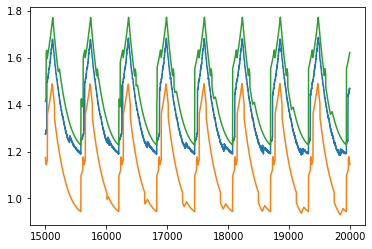

In [8]:
lines = (dp-ts[:,0]).numpy()
plt.plot(np.arange(len(lines))[15000:20000],dp.numpy()[15000:20000],)
plt.plot(np.arange(len(lines))[15000:20000],ts[:,0].numpy()[15000:20000])
plt.plot(np.arange(len(lines))[15000:20000],t_far[gt_mask.squeeze()].max(dim=-1)[0].numpy()[15000:20000])

In [9]:
render_out = torch.load("render_out.pt",map_location="cpu")
tvals = render_out['t_vals'][:,0].numpy()
tfs = render_out['t_vals'].max(dim=-1)[0].numpy()

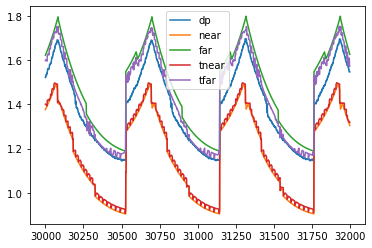

In [10]:
lines = (dp-ts[:,0]).numpy()
plt.plot(np.arange(len(lines))[30000:32000],dp.numpy()[30000:32000],label='dp')
plt.plot(np.arange(len(lines))[30000:32000],ts[:,0].numpy()[30000:32000],label='near')
plt.plot(np.arange(len(lines))[30000:32000],t_far[gt_mask.squeeze()].max(dim=-1)[0].numpy()[30000:32000],label='far')

plt.plot(np.arange(len(lines))[30000:32000],tvals[gt_mask.squeeze()][30000:32000],label='tnear')
plt.plot(np.arange(len(lines))[30000:32000],tfs[gt_mask.squeeze()][30000:32000],label='tfar')


plt.legend()

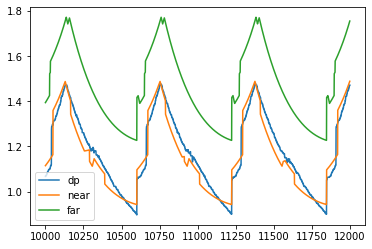

In [49]:
ray_batch = torch.load("ray_batch2.pt",map_location='cpu')
rays_o, rays_d = ray_batch['rays_o'], ray_batch['rays_d']
vox_idx, t_near, t_far = ray_batch['vox_idx'], ray_batch['t_near'], ray_batch['t_far']
hits, gt_rgb = ray_batch['hits'], ray_batch['gt_rgb']
gt_dp = ray_batch['gt_dp']
gt_dp.shape
gt_mask = gt_dp.ne(0.0)
dp = gt_dp[gt_mask]
ts = t_near[gt_mask.squeeze()]
ts.shape
lines = (dp-ts[:,0]).numpy()
plt.plot(np.arange(len(lines))[10000:12000],dp.numpy()[10000:12000],label='dp')
plt.plot(np.arange(len(lines))[10000:12000],ts[:,0].numpy()[10000:12000],label='near')
plt.plot(np.arange(len(lines))[10000:12000],t_far[gt_mask.squeeze()].max(dim=-1)[0].numpy()[10000:12000],label='far')
plt.legend()

# vis depth

In [ ]:
gt = torch.load("gt.pt")
re = torch.load('rend_dp.pt')
img = torch.cat((gt, re, torch.abs(gt-re)),dim=-1).numpy()
plt.imshow(img,cmap="hot")

In [ ]:
gt.max()

## test backproject

In [ ]:
def inv_project_points_cam_coords(intrinsic, uvd, c2w):
    '''
    As inv_project_points but doesn't do the homogeneous transformation
    int: 3x3, uvd:Nx3, c2w:3X4
    '''
    if len(uvd.shape) > 2:
        uvd = uvd.reshape(-1,3)
    if intrinsic.shape[0]>3:
        intrinsic = intrinsic[:3,:3]
    if c2w.shape[0]>3:
        c2w = c2w[:3,:]
    n_points = uvd.shape[0]

    # creating the camera rays
    uv1 = torch.hstack((uvd[:, :2], torch.ones((n_points, 1))))
    camera_rays = torch.mm(intrinsic.inverse(), uv1.T).T

    # forming the xyz points in the camera coordinates
    temp = uvd[:, 2][:,None].repeat(1,3)
    xyz_at_cam_loc = temp * camera_rays
    xyz_at_cam_loc = torch.hstack((xyz_at_cam_loc, torch.ones((n_points, 1))))
    # project to xyz
    xyz_world = torch.mm(c2w, xyz_at_cam_loc.T).T

    return xyz_world

# @torch.jit.script
def re_projection(uvd, intrinsic, c2w):
    '''
    As inv_project_points but doesn't do the homogeneous transformation
    int: 3x3, uvd:Nx3, c2w:3X4
    '''
    if len(uvd.shape) > 2:
        uvd = uvd.reshape(-1,3)
    if intrinsic.shape[0]>3:
        intrinsic = intrinsic[:3,:3]
    if c2w.shape[0]>3:
        c2w = c2w[:3,:]
    n_points = uvd.shape[0]
    



def projection(xyz, K, ext):
    newK = torch.eye(4)
    newK[:3,:3] = K
    P = newK@ext
    uvz = P@xyz
    return uvz, uvz[:2,:]/uvz[2:3,:]

In [ ]:
K = torch.tensor([[300,0,400],[0,300,400],[0,0,1]]).float()
R = torch.eye(3)

In [ ]:
pose = torch.tensor([[1,0,0,0],[0,1,0,0],[0,0,1,-1],[0,0,0,1]]).float()
print(pose)

In [ ]:
Pw = torch.tensor([[3,4,4,1]]).float().T
Pw

In [ ]:
projection(Pw,K,pose.inverse())

In [ ]:
import torch
from typing import Tuple
a = torch.zeros((1))
b = torch.ones((1))
isinstance((a,b), Tuple)

In [ ]:
wd = inv_project_points_cam_coords(K,torch.tensor([682.8427,682.8427,3]).unsqueeze(0),pose)
wd

In [ ]:
wd = inv_project_points_cam_coords(K,torch.tensor([580,640,5]).unsqueeze(0),pose)
wd

In [ ]:
Pc_tmp = torch.ones((4,1))
Pc_tmp[:3,] = Pc_tmp
pose[:3,:]@Pc_tmp

In [ ]:
Pc_tmp

In [ ]:
K

In [ ]:
K.inverse()

# test f.embeding

In [ ]:
import torch.nn.functional as F
import torch

pix_mask = torch.ones((9,16)).long()[0]
feats = torch.randn((9,16,64))[0]
pix_mask

In [ ]:
labels = torch.tensor([0, 1, 0])
x = torch.tensor([[1, 2, 3],[4, 5, 6],[7, 8, 9]])

nrow = torch.unique(labels).size(0)
ncol = x.size(1)
out = torch.zeros((nrow, ncol), dtype=x.dtype)
out.index_add_(0, labels, x)
print(out)

In [ ]:
labels = torch.tensor([0, 2, 1])
x = torch.tensor([[1, 2, 3],[4, 5, 6],[7, 8, 9]])

nrow = torch.unique(labels).size(0)
ncol = x.size(1)
out = torch.zeros((nrow, ncol), dtype=x.dtype)
out.index_add_(0, labels, x)
print(out)

# vis data

In [1]:
tsdf_info = "/home/yangchen/projects/SLAM_systems/Accel-RF/demo_dir/scannet/all_tsdf_9/scene0079_00/tsdf_info.pkl"
fragments = "/home/yangchen/projects/SLAM_systems/Accel-RF/demo_dir/scannet/all_tsdf_9/scene0158_00/fragments.pkl"
import pickle

In [2]:
with open(fragments, "rb") as f:
    data = pickle.load(f)

In [3]:
tmp = []
for i in range(len(data)):
    tmp.extend(data[i]['image_ids'])
len(tmp)
data

[{'scene': 'scene0158_00',
  'fragment_id': 0,
  'image_ids': [0, 43, 52, 61, 90, 100, 132, 189, 212],
  'vol_origin': array([-0.8618307, -1.593297 , -1.1892471], dtype=float32),
  'voxel_size': 0.04},
 {'scene': 'scene0158_00',
  'fragment_id': 1,
  'image_ids': [213, 237, 260, 280, 293, 315, 330, 343, 359],
  'vol_origin': array([-0.8618307, -1.593297 , -1.1892471], dtype=float32),
  'voxel_size': 0.04},
 {'scene': 'scene0158_00',
  'fragment_id': 2,
  'image_ids': [360, 400, 412, 424, 431, 438, 467, 478, 490],
  'vol_origin': array([-0.8618307, -1.593297 , -1.1892471], dtype=float32),
  'voxel_size': 0.04},
 {'scene': 'scene0158_00',
  'fragment_id': 3,
  'image_ids': [491, 509, 523, 551, 557, 567, 588, 614, 623],
  'vol_origin': array([-0.8618307, -1.593297 , -1.1892471], dtype=float32),
  'voxel_size': 0.04},
 {'scene': 'scene0158_00',
  'fragment_id': 4,
  'image_ids': [624, 658, 682, 690, 696, 723, 786, 838, 856],
  'vol_origin': array([-0.8618307, -1.593297 , -1.1892471], dtype

# check items

In [ ]:
@torch.jit.script
def get_points_vox(center_pts: torch.Tensor, voxel_size: float=0.04, pt_pervox:int=8):
    '''
        input: center_pts: N, 3
        sample_pts: N, 512, 3
    '''
    xv, yv, zv = torch.meshgrid(
        torch.arange(0, pt_pervox),
        torch.arange(0, pt_pervox),
        torch.arange(0, pt_pervox),
    )
    vox_coords = torch.stack([xv.flatten(), yv.flatten(), zv.flatten()], dim=1).long().to(center_pts.device) # 512, 3
    sample_pts = (center_pts - voxel_size*0.5)[:,None] + (vox_coords*voxel_size/pt_pervox).unsqueeze(0)
    return sample_pts

In [37]:
import torch
a = torch.arange(8).reshape(2,2,2)
a

tensor([[[0, 1],
         [2, 3]],

        [[4, 5],
         [6, 7]]])

In [38]:
a.repeat(2,2,2)

tensor([[[0, 1, 0, 1],
         [2, 3, 2, 3],
         [0, 1, 0, 1],
         [2, 3, 2, 3]],

        [[4, 5, 4, 5],
         [6, 7, 6, 7],
         [4, 5, 4, 5],
         [6, 7, 6, 7]],

        [[0, 1, 0, 1],
         [2, 3, 2, 3],
         [0, 1, 0, 1],
         [2, 3, 2, 3]],

        [[4, 5, 4, 5],
         [6, 7, 6, 7],
         [4, 5, 4, 5],
         [6, 7, 6, 7]]])

In [31]:
xv, yv, zv = torch.meshgrid(
    torch.arange(0, 2),
    torch.arange(0, 2),
    torch.arange(0, 2),
)
vox_coords = torch.stack([xv.flatten(), yv.flatten(), zv.flatten()], dim=1).long()
vox_coords.reshape(2,2,2,3)

tensor([[[[0, 0, 0],
          [0, 0, 1]],

         [[0, 1, 0],
          [0, 1, 1]]],


        [[[1, 0, 0],
          [1, 0, 1]],

         [[1, 1, 0],
          [1, 1, 1]]]])

In [11]:
a.size()

torch.Size([3, 3, 3])

In [16]:
sh = a.shape

In [20]:
b = torch.zeros(sh)
b.flatten().view(sh)

tensor([[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]])

torch.Size([24])

In [34]:
a = torch.arange(0,64)
a = a.reshape(2,2,2,8)
a

tensor([[[[ 0,  1,  2,  3,  4,  5,  6,  7],
          [ 8,  9, 10, 11, 12, 13, 14, 15]],

         [[16, 17, 18, 19, 20, 21, 22, 23],
          [24, 25, 26, 27, 28, 29, 30, 31]]],


        [[[32, 33, 34, 35, 36, 37, 38, 39],
          [40, 41, 42, 43, 44, 45, 46, 47]],

         [[48, 49, 50, 51, 52, 53, 54, 55],
          [56, 57, 58, 59, 60, 61, 62, 63]]]])

In [35]:
a.reshape(4,4,4)

tensor([[[ 0,  1,  2,  3],
         [ 4,  5,  6,  7],
         [ 8,  9, 10, 11],
         [12, 13, 14, 15]],

        [[16, 17, 18, 19],
         [20, 21, 22, 23],
         [24, 25, 26, 27],
         [28, 29, 30, 31]],

        [[32, 33, 34, 35],
         [36, 37, 38, 39],
         [40, 41, 42, 43],
         [44, 45, 46, 47]],

        [[48, 49, 50, 51],
         [52, 53, 54, 55],
         [56, 57, 58, 59],
         [60, 61, 62, 63]]])

In [39]:
a

tensor([[[0, 1],
         [2, 3]],

        [[4, 5],
         [6, 7]]])

In [42]:
b = (a-2)
print(b)
x,y,z = torch.where(b>0)

tensor([[[-2, -1],
         [ 0,  1]],

        [[ 2,  3],
         [ 4,  5]]])


In [47]:
for i in range(len(x)):
    print(x[i])

tensor(0)
tensor(1)
tensor(1)
tensor(1)
tensor(1)


### test code 

In [5]:
from typing import Dict, Tuple, Optional
import torch
from torch import Tensor
sigma = 0.2
a = torch.distributions.normal.Normal(torch.tensor(0.), torch.tensor(sigma/3))

In [6]:
INF = 1e6
dp_mask = torch.tensor([[1,2,3,0,0],[1,2,3,0,0]])

dp_mask.masked_fill_(dp_mask.eq(0.0), INF)



tensor([[      1,       2,       3, 1000000, 1000000],
        [      1,       2,       3, 1000000, 1000000]])

In [7]:
a.log_prob(0).exp()

tensor(5.9841)

In [4]:
a.log_prob(0).exp()

tensor(59.8413)

In [5]:
import math

func = lambda x: math.exp(-(x**2)/(2*(sigma/3)**2))/(math.sqrt(2*math.pi)*(sigma/3))
func(sigma)

0.6647772617907017

# vis the weight distribution

In [2]:
rout = torch.load("vis_dp.pt",map_location='cpu')
rout.keys()

dict_keys(['rgb', 'depth', 'weights', 't_vals'])

In [3]:
num = 3
base = np.random.randint(32000)
dp = torch.load('dp.pt')
dp_mk = dp.ne(0.0)
num = dp_mk.sum()

In [4]:
near = rout['t_vals'][:,0]
far = rout['t_vals'].max(dim=-1)[0]

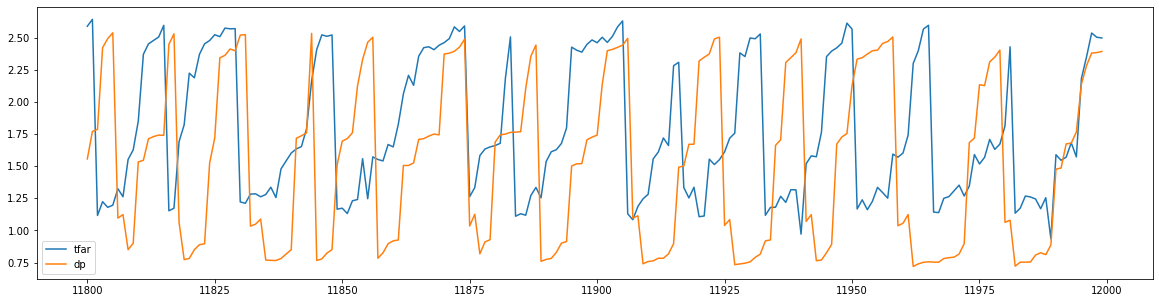

In [8]:
plt.figure(figsize=(20, 5))

# plt.plot(np.arange(num.item())[11800:12000],near[dp_mk][11800:12000],label='tnear')
plt.plot(np.arange(num.item())[11800:12000],far[dp_mk][11800:12000],label='tfar')
plt.plot(np.arange(num.item())[11800:12000],dp[dp_mk].numpy()[11800:12000],label='dp')

plt.legend()

In [6]:
dp = torch.load('dp.pt')
dp_mask = dp.ne(0.0)
dp = dp[dp_mask]
we = rout['weights'].detach()[dp_mask]
tv = rout['t_vals'].detach()[dp_mask]

In [7]:
tv_max_idx = torch.argmax(tv,dim=-1)
tv_max_idx

tensor([12, 10,  9,  ..., 12, 13, 12])

In [8]:
we_all = []
for index,i in enumerate(tv_max_idx):
    we_all.append(we[index][i])
we_all = torch.stack(we_all)
we_all.shape

torch.Size([30445])

In [9]:
tv_all = []
for index,i in enumerate(tv_max_idx):
    tv_all.append(tv[index][i])
tv_all = torch.stack(tv_all)
tv_all.shape

torch.Size([30445])

In [23]:
dists = (tv_all-dp)
dists.max()-dists.min()
dists = dists.numpy()

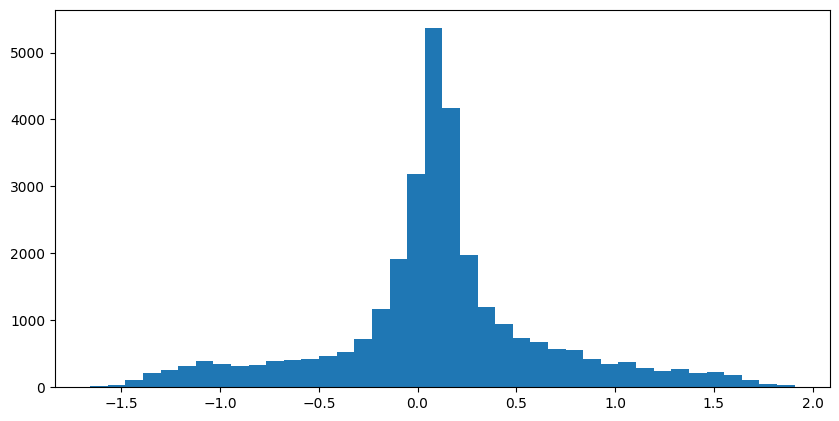

In [27]:
plt.figure(figsize=(10, 5), dpi=100)
n, bins, patches=plt.hist(dists, bins=40)
plt.show()
# plt.grid(linestyle="--", alpha=0.5)

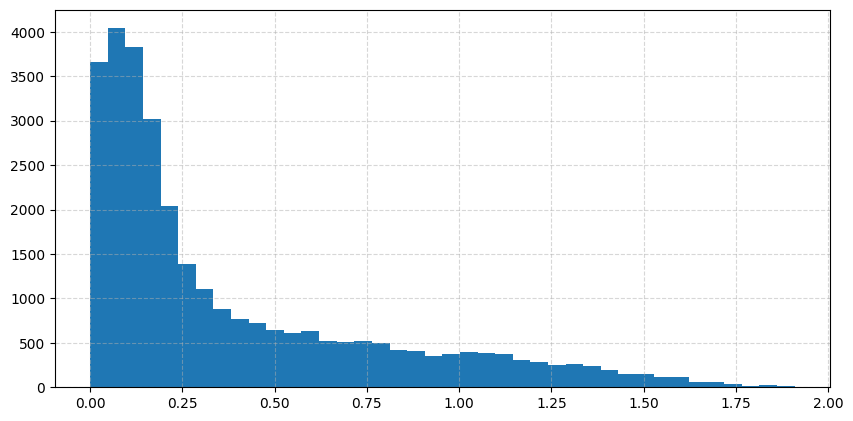

In [44]:
plt.figure(figsize=(10, 5), dpi=100)
n, bins, patches=plt.hist(np.abs(dists), bins=40)
plt.grid(linestyle="--", alpha=0.5)
plt.show()

In [37]:
sum(n[:6])/sum(n)

0.5906060108392183

In [49]:
sum(n[7:])

11357.0

In [2]:
# def inv_project_points_cam_coords(self, uvd):
#     '''
#     As inv_project_points but doesn't do the homogeneous transformation
#     '''
#     assert(uvd.shape[1] == 3)
#     n_points = uvd.shape[0]

#     # creating the camera rays
#     uv1 = np.hstack((uvd[:, :2], np.ones((n_points, 1))))
#     camera_rays = np.dot(self.inv_K, uv1.T).T

#     # forming the xyz points in the camera coordinates
#     temp = uvd[:, 2][np.newaxis, :].T
#     xyz_at_cam_loc = temp * camera_rays

#     return xyz_at_cam_loc
import numpy as np
uv1 = np.ones((10,3))
uv1[:, 2][np.newaxis, :].T.shape

(10, 1)

### vis the heapmap

In [1]:
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

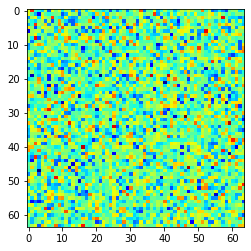

In [27]:
a = np.ones((64,64))
b = np.random.randn(64,64)
pred=a-b


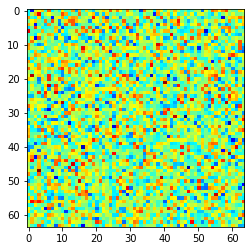

In [28]:
c = (((b-b.min())/(b.max()-b.min()))*255.).astype(np.uint8)

heatmapshow = cv2.applyColorMap(c, cv2.COLORMAP_JET)
plt.imshow(heatmapshow)

In [29]:
((b-b.min())/(b.max()-b.min()))

array([[0.61592862, 0.87273468, 0.4335379 , ..., 0.53953253, 0.35104584,
        0.38054453],
       [0.63004619, 0.44437253, 0.30303621, ..., 0.51843438, 0.50505632,
        0.47265377],
       [0.2771821 , 0.56130539, 0.63147797, ..., 0.34528985, 0.24665162,
        0.31279879],
       ...,
       [0.51963481, 0.31444067, 0.43800668, ..., 0.37483333, 0.76794923,
        0.4972136 ],
       [0.46037134, 0.31162894, 0.46694886, ..., 0.49166603, 0.43480101,
        0.59048415],
       [0.44074585, 0.55217485, 0.61815319, ..., 0.43937858, 0.70599868,
        0.69715758]])

In [44]:
a = torch.tensor([[1,2,3],[1,2,3]]).float()
a.sum(-1,keepdim=True).shape

torch.Size([2, 1])

In [46]:
a = torch.zeros(3)
a
a/a.sum(-1)

tensor([nan, nan, nan])